In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

from keras import regularizers, optimizers
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.models import Sequential,load_model
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras import backend as K

from tensorflow.keras.callbacks import History,EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError as rmse

from scripts_ import *

import warnings
warnings.filterwarnings("ignore")

In [27]:
data = pd.read_csv("modelling_data.csv")

In [28]:
data.columns

Index(['Unnamed: 0', 'total_cases_per_million', 'new_cases_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'reproduction_rate', 'icu_patients_per_million',
       'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
       'weekly_hosp_admissions_per_million', 'new_tests_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'stringency_index', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'C1_School closing', 'C2_Workplace closing',
       'C3_Cancel public events', 'C4_Restrictions on gatherings',
       'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_

In [29]:
countries,scaler  = general_data_prep(data,shift=14)

Index(['total_cases_per_million', 'new_cases_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'reproduction_rate', 'hosp_patients_per_million',
       'new_tests_per_thousand', 'positive_rate', 'tests_per_case',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'hospital_beds_per_thousand', 'life_expectancy',
       'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
       'H7_Vaccination policy', 'H8_Protection of elderly people',
       'mobility_recreation', 'mobility_grocery', 'mobility_parks',
       'mobility_t

In [42]:
with open("scaler.pkl","wb")  as file:
    pickle.dump(scaler,file)

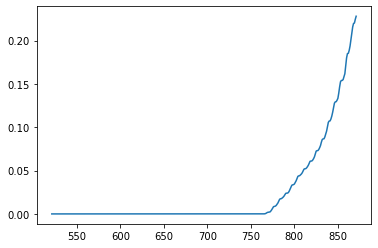

In [30]:
plt.plot(countries["belgium"].total_vaccinations_per_hundred)

In [31]:
cols_not = ["total_deaths_per_million","new_deaths_per_million","hosp_patients_per_million",
            'new_tests_per_thousand', 'positive_rate','tests_per_case',"reproduction_rate","total_cases_per_million", 'cardiovasc_death_rate',
       'diabetes_prevalence', 'hospital_beds_per_thousand', 'life_expectancy']

In [32]:
X_train,X_test,y_train,y_test = prep_sequences(countries,cols_not,"new_cases_per_million")

In [33]:
X_train.shape

(2451, 90, 25)

In [34]:
model = Sequential()

model.add(LSTM(256,input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(Activation("relu"))
model.add(Dropout(0))

model.add(LSTM(256,return_sequences=True))
model.add(Activation("relu"))
model.add(Dropout(0))


model.add(LSTM(128))
model.add(Activation("relu"))
model.add(Dropout(0))


model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0))


model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0))



model.add(Dense(1,activation="linear"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 90, 256)           288768    
_________________________________________________________________
activation_10 (Activation)   (None, 90, 256)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 90, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 90, 256)           525312    
_________________________________________________________________
activation_11 (Activation)   (None, 90, 256)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 90, 256)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)              

In [35]:
history = History()
Adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
early_s = EarlyStopping(monitor = "val_loss",patience = 8)
model.compile(loss="mse",optimizer=Adam,metrics=[rmse()])

In [36]:
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=35,batch_size=32,callbacks=[history,early_s])

Epoch 1/35
77/77 [==============================] - 47s 497ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 2/35
77/77 [==============================] - 36s 466ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 5.7437e-04 - val_root_mean_squared_error: 0.0240
Epoch 3/35
77/77 [==============================] - 36s 463ms/step - loss: 7.5399e-04 - root_mean_squared_error: 0.0274 - val_loss: 3.8193e-04 - val_root_mean_squared_error: 0.0195
Epoch 4/35
77/77 [==============================] - 37s 475ms/step - loss: 3.5469e-04 - root_mean_squared_error: 0.0188 - val_loss: 2.4379e-04 - val_root_mean_squared_error: 0.0156
Epoch 5/35
77/77 [==============================] - 37s 478ms/step - loss: 2.2827e-04 - root_mean_squared_error: 0.0151 - val_loss: 2.1139e-04 - val_root_mean_squared_error: 0.0145
Epoch 6/35
77/77 [==============================] - 36s 475ms/step - loss: 2.7637e-04 - root_mean_squared_e

In [39]:
model.save("cases_model.keras")

# Evaluations

Evaluations are performed on 3 series per country, predicting 60 steps ahead based on real values of restrictions, mobility and vaccinatios metrics, predicting one step ahead recursionally. Results are evaluated using mean squared error and R2_score. Mean error and r2 score are printed at the end of the process.

In [13]:
# reverse scaler preparation
reverse_scaler = MinMaxScaler()
reverse_scaler.min_,reverse_scaler.scale_ = scaler.min_[2], scaler.scale_[2]

COUNTRY: belgium


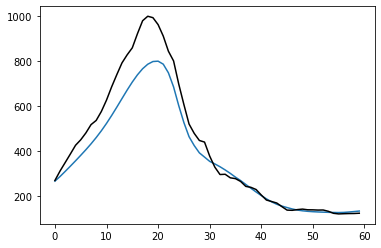

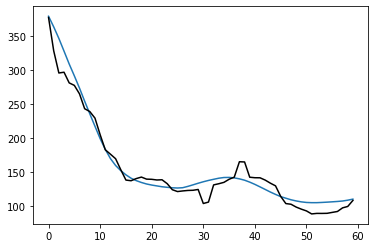

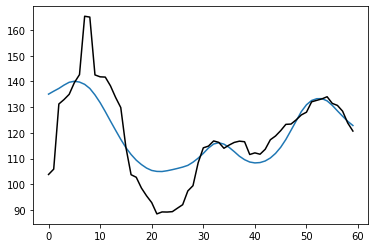

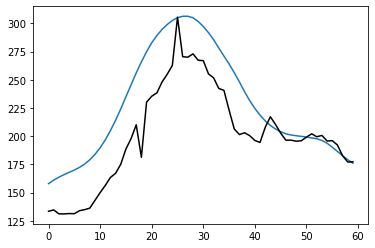

COUNTRY: france


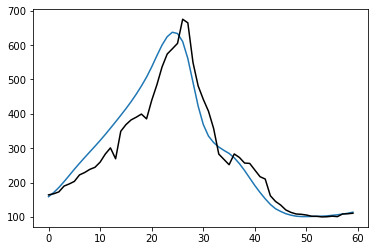

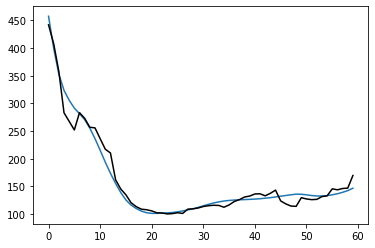

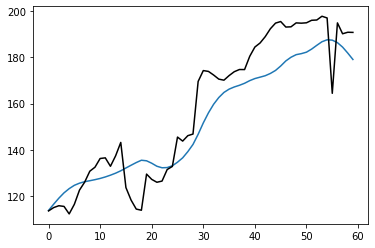

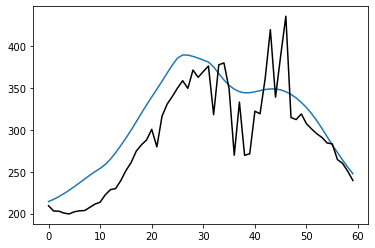

COUNTRY: germany


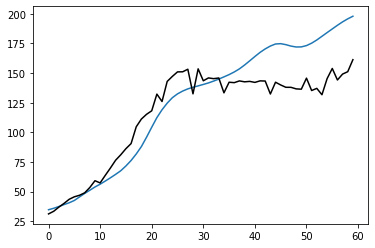

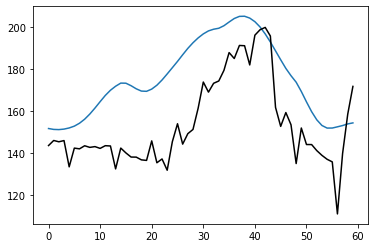

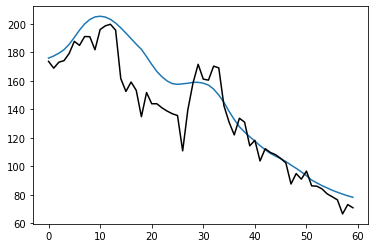

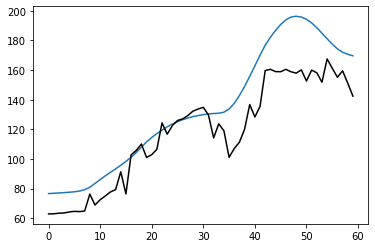

COUNTRY: israel


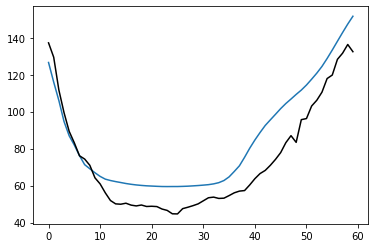

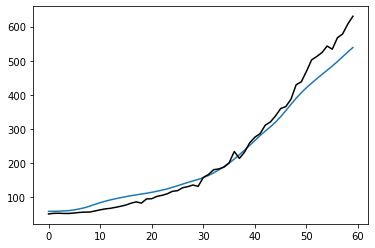

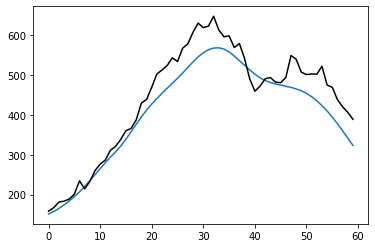

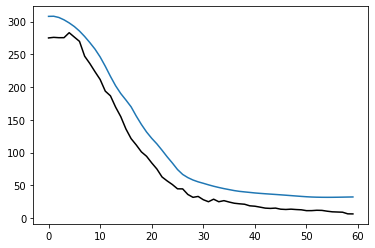

COUNTRY: italy


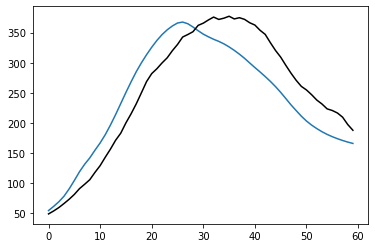

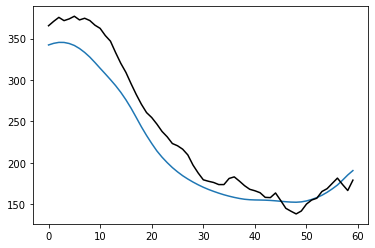

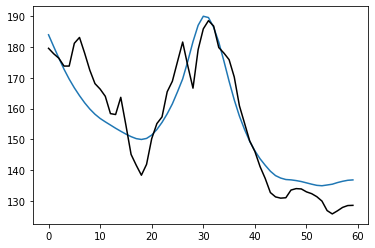

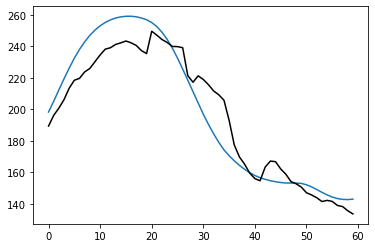

COUNTRY: sweden


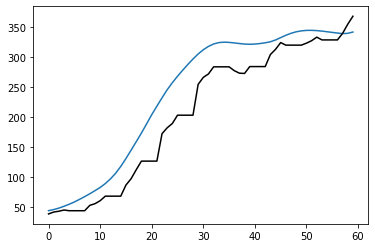

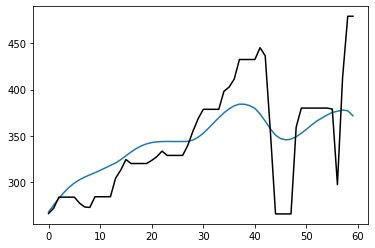

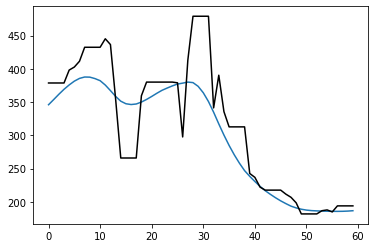

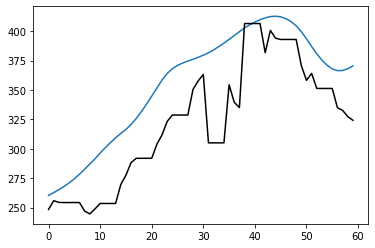

COUNTRY: poland


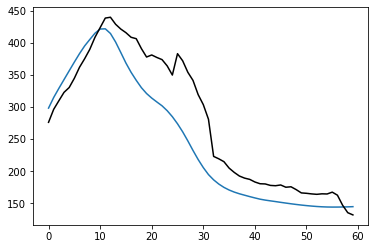

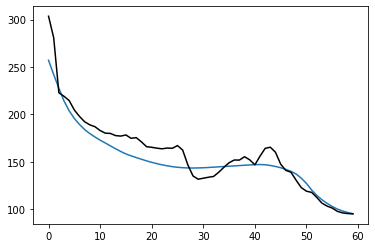

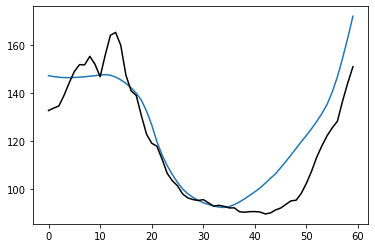

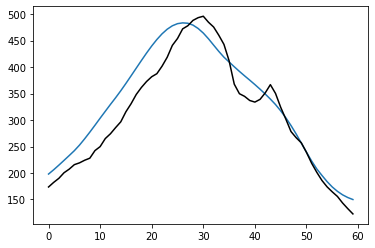

COUNTRY: uk


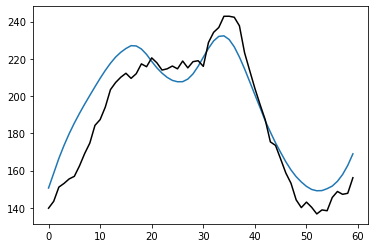

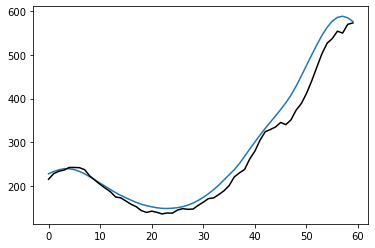

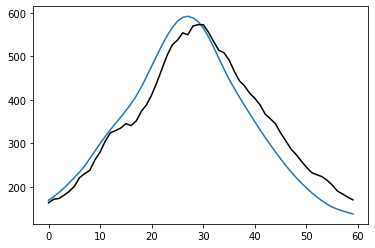

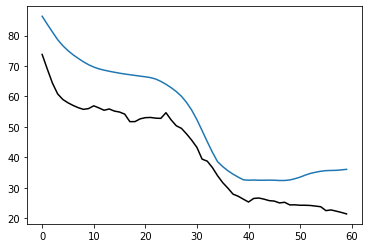

COUNTRY: austria


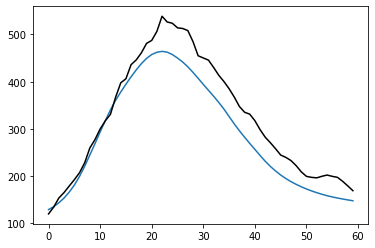

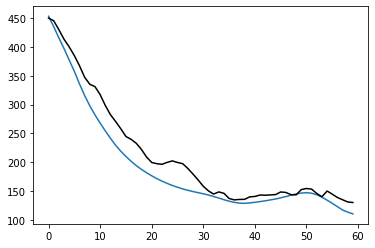

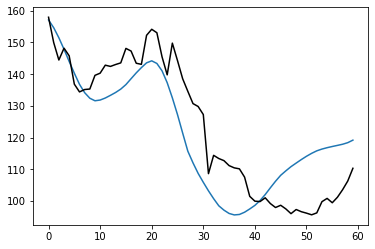

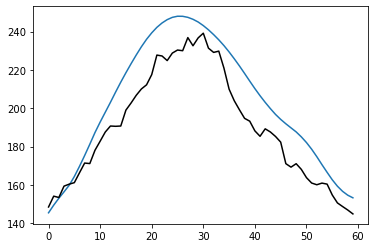

COUNTRY: netherlands


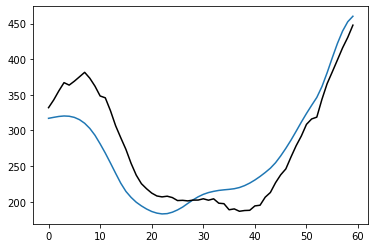

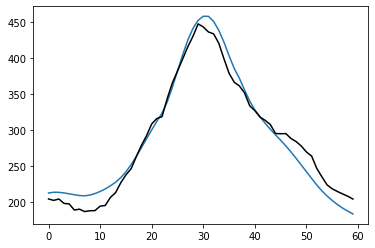

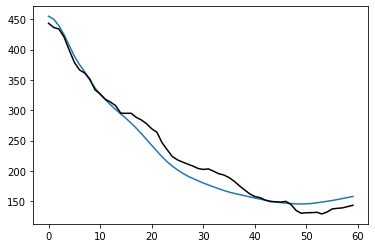

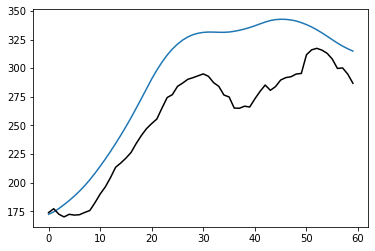

COUNTRY: spain


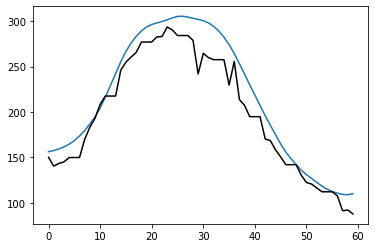

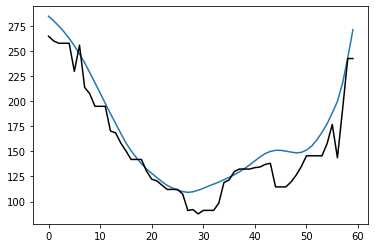

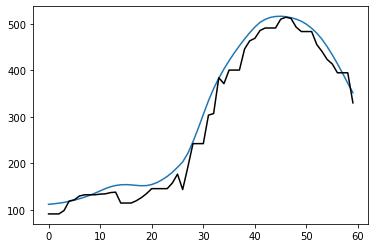

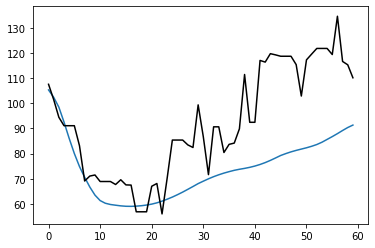

COUNTRY: portugal


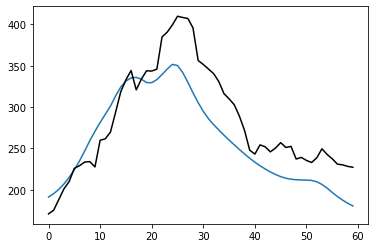

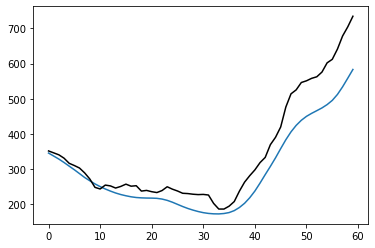

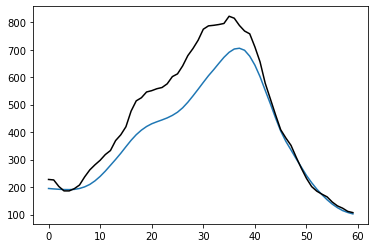

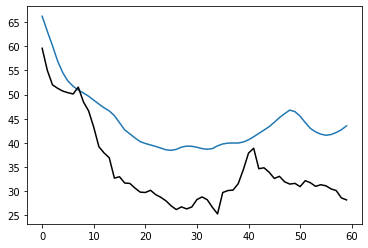

 Root mean squared error for set: 34.383946546688605, R2 score 0.7171460440158196


In [37]:
# evaluate set on 60-step forward prediction
evaluate_set(countries,reverse_scaler,model,0)

COUNTRY: poland


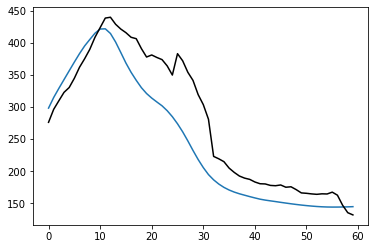

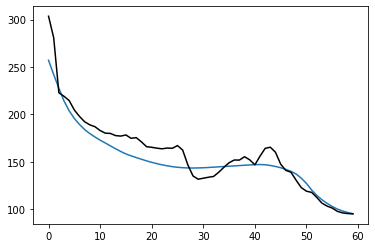

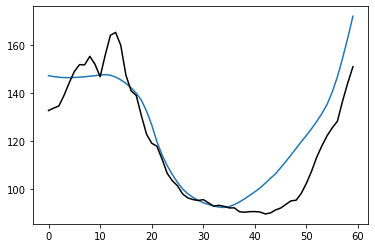

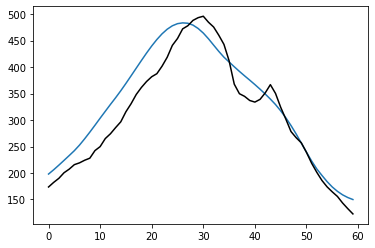

 Root mean squared error for set: 31.00291262406963, R2 score 0.8349574776904743


In [38]:
poland = {
    "poland":countries["poland"]
}
evaluate_set(poland,reverse_scaler,model,0)

# EVALUATION 2
How model reacts to changes in mobility, restrictions and vaccinations. Desired effect is that cases curve flattens with more vaccinations, with tighter restrictions and with lower social mobility.

## Changing vaccinations

In [14]:
# data_eval for real value predictions
data_eval = countries["poland"].iloc[-150:,:].copy()

In [15]:
# evaluation data in form of numpy matrix
data_eval_pred = data_eval.to_numpy()

# setting last 60 steps of target value to zero
data_eval_pred[90:,0] = 0

# in a loop - predicting target values 60 steps ahead
for i in range(60):
    pred_data = data_eval_pred[i:90+i,:]
    value = model.predict(pred_data.reshape(1,90,25))
    data_eval_pred[90+i,0] = value
predictions = data_eval_pred[90:,0]

In [16]:
# data eval for changed values prediction
data_eval = countries["poland"].iloc[-150:,:].copy()

In [17]:
def interpolate_column(column,rng,value):
    column[-rng:] = np.NaN
    column.iloc[-1] = value
    column = column.interpolate()
    return column

In [18]:
# changing values of columns 
data_eval["total_vaccinations_per_hundred"] = interpolate_column(data_eval["total_vaccinations_per_hundred"],100,0.8)
data_eval["people_vaccinated_per_hundred"] = interpolate_column(data_eval["people_vaccinated_per_hundred"],100,0.7)
data_eval["people_fully_vaccinated_per_hundred"] = interpolate_column(data_eval["people_fully_vaccinated_per_hundred"],100,0.6)

In [19]:
# predicting with changed values

data_eval_pred = data_eval.copy().to_numpy()

vals = []
for i in range(60):
    pred_data = data_eval_pred[i:90+i,:]
    value = model.predict(pred_data.reshape(1,90,25))
    data_eval_pred[90+i,0] = value

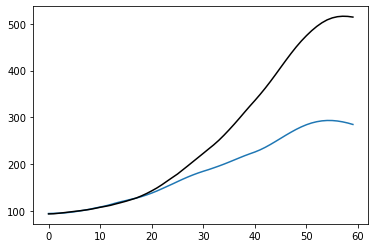

In [20]:
# plotting prediction with and without changed values

plt.figure()
plt.plot(reverse_scaler.inverse_transform(data_eval_pred[90:,0].reshape(-1, 1)))
plt.plot(reverse_scaler.inverse_transform(predictions.reshape(-1,1)),color="black")
plt.show()


### Changing restrictions

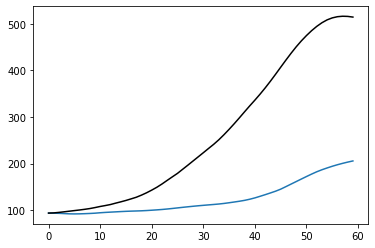

In [21]:
data_eval = countries["poland"].iloc[-150:,:].copy()

data_eval = data_eval.append(pd.DataFrame(np.zeros((60,25),"float"),columns=data_eval.columns),ignore_index=True)

# evaluation data in form of numpy matrix
data_eval_pred = data_eval.to_numpy()

# setting last 60 steps of target value to zero
data_eval_pred[90:,0] = 0

# in a loop - predicting target values 60 steps ahead
for i in range(60):
    pred_data = data_eval_pred[i:90+i,:]
    value = model.predict(pred_data.reshape(1,90,25))
    data_eval_pred[90+i,0] = value
predictions = data_eval_pred[90:,0]



data_eval = countries["poland"].iloc[-150:,:].copy()


restrictions = ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings',
       'H7_Vaccination policy', 'H8_Protection of elderly people']

for col in restrictions:
    data_eval[col][-60:]= 1


data_eval_pred = data_eval.copy().to_numpy()

vals = []
for i in range(60):
    pred_data = data_eval_pred[i:90+i,:]
    value = model.predict(pred_data.reshape(1,90,25))
    data_eval_pred[90+i,0] = value

plt.figure()
plt.plot(reverse_scaler.inverse_transform(data_eval_pred[90:,0].reshape(-1, 1)))
plt.plot(reverse_scaler.inverse_transform(predictions[:60].reshape(-1,1)),color="black")
plt.show()


## Changing mobility

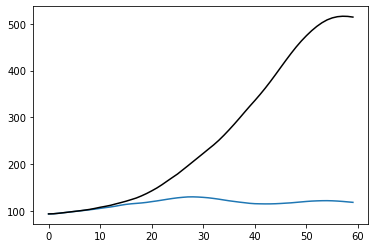

In [22]:
data_eval = countries["poland"].iloc[-150:,:].copy()

data_eval = data_eval.append(pd.DataFrame(np.zeros((60,25),"float"),columns=data_eval.columns),ignore_index=True)

# evaluation data in form of numpy matrix
data_eval_pred = data_eval.to_numpy()

# setting last 60 steps of target value to zero
data_eval_pred[90:,0] = 0

# in a loop - predicting target values 60 steps ahead
for i in range(60):
    pred_data = data_eval_pred[i:90+i,:]
    value = model.predict(pred_data.reshape(1,90,25))
    data_eval_pred[90+i,0] = value
predictions = data_eval_pred[90:,0]



data_eval = countries["poland"].iloc[-150:,:].copy()



mobility = ['mobility_recreation', 'mobility_grocery', 'mobility_parks',
       'mobility_transit', 'mobility_work', 'mobility_residential']
for col in mobility:
    data_eval[col] = interpolate_column(data_eval[col],60,-0.5)


data_eval_pred = data_eval.copy().to_numpy()

vals = []
for i in range(60):
    pred_data = data_eval_pred[i:90+i,:]
    value = model.predict(pred_data.reshape(1,90,25))
    data_eval_pred[90+i,0] = value

plt.figure()
plt.plot(reverse_scaler.inverse_transform(data_eval_pred[90:,0].reshape(-1, 1)))
plt.plot(reverse_scaler.inverse_transform(predictions[:60].reshape(-1,1)),color="black")
plt.show()


In each case values of predictions after significant change in vaccinations, restrictions or mobility are much lower than values predicted before that change. That means, that desired effect was achieved